# Import packages and libraries

In [1]:
!pip install emoji
!pip install spacy
!python -m spacy download nl_core_news_sm
!pip install stopwordsiso
!pip install langdetect

import string
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('pos_tag')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

import spacy
from spacy.symbols import nsubj, VERB, ADJ
nlp = spacy.load("nl_core_news_sm")

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim import corpora, models
from gensim.models import Phrases
from gensim.corpora import Dictionary

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn import cluster

from stopwordsiso import stopwords

from langdetect import detect

import emoji
import pandas as pd

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=68d131752d29a3855439868fec4bbb7a66f435bcc276da1d507548804ce6bb86
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji
2023-07-05 19:38:24.716683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 19:38:26.225120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spac

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Error loading pos_tag: Package 'pos_tag' not found in
[nltk_data]     index
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Read in the data

In [4]:
# Read the Excel file
df = pd.read_excel("/content/xxxxx.xlsx")

#Exploration of the data

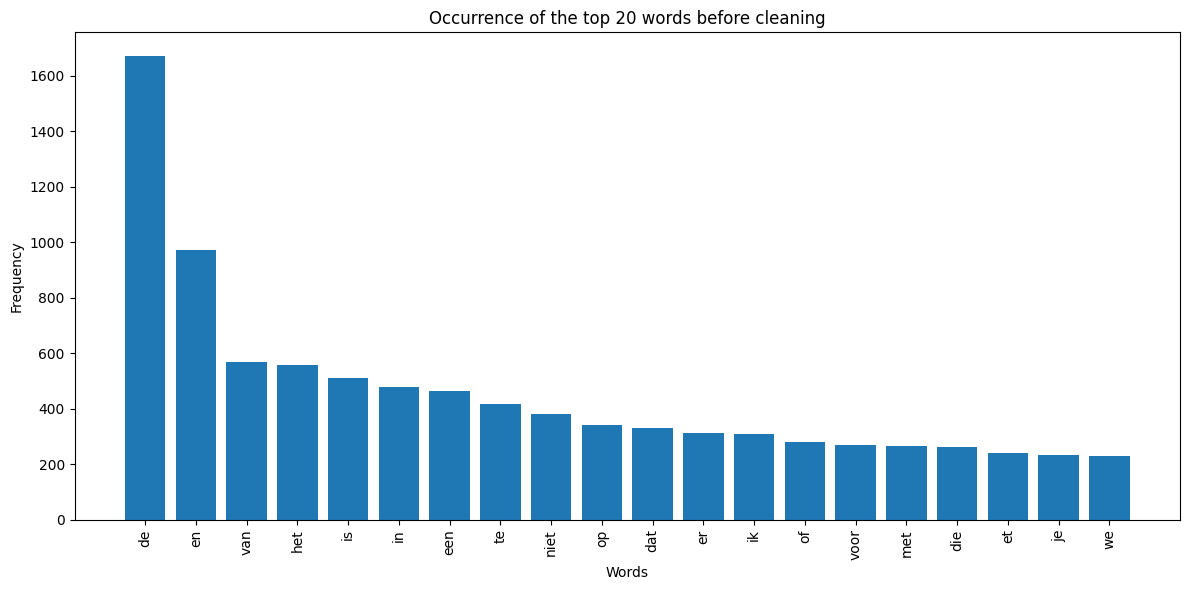

In [5]:
# Calculate the frequency of words
word_frequency = {}

# Iterate over each row in the 'Antwoord' column
for row in df['Antwoord']:
    # Check if the row is not NaN
    if isinstance(row, str):
        # Iterate over each word in the row
        for word in row.split():
            # Update the frequency count for the word
            if word in word_frequency:
                word_frequency[word] += 1
            else:
                word_frequency[word] = 1

# Create lists to store the words and their frequencies
words = []
frequencies = []

# Sort the word frequencies in descending order
sorted_word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)

# Extract the top 20 sorted words and frequencies into separate lists
top_20_words = sorted_word_frequency[:20]
for word, frequency in top_20_words:
    words.append(word)
    frequencies.append(frequency)

# Increase the figure size
plt.figure(figsize=(12, 6))

# Create a bar chart for the top 20 words
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation='vertical')
plt.title('Occurrence of the top 20 words before cleaning')
plt.tight_layout()
plt.show()

In [6]:
# Print maximum lenght of answers
max_length = df["Antwoord"].str.len().max()
print("Maximum length of 'Antwoord' column:", max_length)

# Print mean lenght of answers
mean_length = df["Antwoord"].str.len().mean()
print("Mean length of 'Antwoord' column:", mean_length)

Maximum length of 'Antwoord' column: 2810.0
Mean length of 'Antwoord' column: 158.02766179540708


#Cleaning of the data

## Remove non-Dutchlanguages

In [7]:
# Define the column to check the language
column_to_check = "Antwoord"

# Iterate over the rows and detect the language in the specified column
rows_to_drop = []
for index, row in df.iterrows():
    try:
        text = str(row[column_to_check])
        language = detect(text)
        if language != 'nl':
            rows_to_drop.append(index)
    except:
        continue

# Drop the rows that have non-Dutch language
df.drop(rows_to_drop, axis=0, inplace=True)

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

In [12]:
# Convert the 'Antwoord' column to string type
df["Antwoord"] = df["Antwoord"].astype(str)

# Tokenize the text into individual words for each row
tokens = df['Antwoord'].apply(nltk.word_tokenize)

# Initializes the WordNet Lemmatizer from the NLTK library
lemmatizer = nltk.stem.WordNetLemmatizer()

# Lemmatize each word in the tokens for each row
df['lemmatized_words'] = tokens.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Convert the lists of words to lowercase
df['cleanned_text'] = df['lemmatized_words'].apply(lambda x: [word.lower() for word in x])

# Removing digits
df['cleanned_text'] = df['cleanned_text'].apply(lambda x: [word for word in x if not word.isdigit()])

# Removing punctuations
df['cleanned_text'] = df['cleanned_text'].apply(lambda x: [word.translate(str.maketrans('', '', string.punctuation)) for word in x])

# Remove emojis using the emoji library
df['cleanned_text'] = df['cleanned_text'].apply(lambda x: [emoji.demojize(word, delimiters=(":", ": ")) for word in x])

# Remove emoji descriptions
df['cleanned_text'] = df['cleanned_text'].apply(lambda x: [word for word in x if not word.startswith(':')])

# Remove words with less than 3 letters
df['cleanned_text'] = df['cleanned_text'].apply(lambda x: [word for word in x if len(word) >= 3])

## Check extra stopwords

Count of 'nee': 90
Count of 'niks': 10
Count of 'nvt': 1
Count of 'nan': 41
Count of 'bedrijf': 342
Count of 'neen': 30
Total: 82


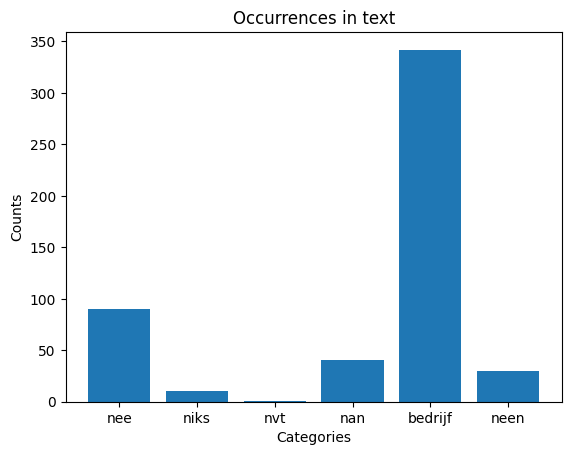

In [13]:
# Replace empty strings with 'nan' in the 'cleanned_text' column
df['cleanned_text'] = df['cleanned_text'].apply(lambda row: ['nan'] if len(row) == 0 else row)

# Count occurrences of "nee","niks" "nvt" in the 'cleanned_text' column
nee_count = df['cleanned_text'].apply(lambda x: x.count('nee')).sum()
niks_count = df['cleanned_text'].apply(lambda x: x.count('niks')).sum()
nvt_count = df['cleanned_text'].apply(lambda x: x.count('nvt')).sum()
nan_count = df['cleanned_text'].apply(lambda x: x.count('nan')).sum()
bedrijf_count = df['cleanned_text'].apply(lambda x: x.count('bedrijf')).sum()
neen_count = df['cleanned_text'].apply(lambda x: x.count('neen')).sum()

# Print the counts
print("Count of 'nee':", nee_count)
print("Count of 'niks':", niks_count)
print("Count of 'nvt':", nvt_count)
print("Count of 'nan':", nan_count)
print("Count of 'bedrijf':", bedrijf_count)
print("Count of 'neen':", neen_count)
print("Total:", neen_count+niks_count+nvt_count+nan_count)

# Create a bar chart
labels = ['nee', 'niks', 'nvt', 'nan', 'bedrijf','neen']
counts = [nee_count, niks_count, nvt_count, nan_count, bedrijf_count, neen_count]
plt.bar(labels, counts)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Occurrences in text')

# Show the bar chart
plt.show()

## Remove extra stopword

In [14]:
from stopwordsiso import stopwords

# Define additional stopwords to be added
additional_stopwords = ['nee', 'niks', 'nvt', 'nan', 'bedrijf', 'neen']

# Initialize the stopwordsiso for Dutch
stopwords_dutch_extended = stopwords("nl")

# Extend the stopwords list
stopwords_dutch_extended.update(additional_stopwords)

# Remove stopwords
df['cleanned_text'] = df['cleanned_text'].apply(lambda x: [word for word in x if word not in stopwords_dutch_extended])

# Strip whitespaces
df['cleanned_text'] = df['cleanned_text'].apply(lambda x: [word.strip() for word in x])

df.head(10)

,Vraag,Antwoord,lemmatized_words,cleanned_text
0,Zijn er andere thema's en onderwerpen waarover...,"Nee, informatievoorziening prima op orde","[Nee, ,, informatievoorziening, prima, op, orde]","[informatievoorziening, prima, orde]"
1,Zijn er andere thema's en onderwerpen waarover...,Neen,[Neen],[]
2,Zijn er andere thema's en onderwerpen waarover...,Aanbestedingen en onderhoudscontracten. Het pe...,"[Aanbestedingen, en, onderhoudscontracten, ., ...","[aanbestedingen, onderhoudscontracten, persone..."
3,Zijn er andere thema's en onderwerpen waarover...,geen andere them's,"[geen, andere, them, 's]",[them]
4,Zijn er andere thema's en onderwerpen waarover...,Nee,[Nee],[]
5,Zijn er andere thema's en onderwerpen waarover...,Geen andere thema's en onderwerpen,"[Geen, andere, thema, 's, en, onderwerpen]","[thema, onderwerpen]"
6,Zijn er andere thema's en onderwerpen waarover...,Werkvoorraad,[Werkvoorraad],[werkvoorraad]
7,Zijn er andere thema's en onderwerpen waarover...,Waar staat *Bedrijf* over 2 of 3 jaar?,"[Waar, staat, *, Bedrijf, *, over, 2, of, 3, j...","[staat, jaar]"
8,Zijn er andere thema's en onderwerpen waarover...,Nee,[Nee],[]
9,Zijn er andere thema's en onderwerpen waarover...,Ik krijg voldoende informatie om mijn werk opt...,"[Ik, krijg, voldoende, informatie, om, mijn, w...","[krijg, voldoende, informatie, werk, optimaal,..."
